In [1]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
minorLocator   = MultipleLocator(2)

# Load installed sources

In [2]:
sources = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','source','source_version','release','last_updated','type'], dtype=object)
sources.shape

(46272487, 6)

In [3]:
sources.drop_duplicates(inplace=True)
sources.shape

(25953301, 6)

# Vulnerability report

In [4]:
vuls = pd.read_csv('../../data/for_analysis/vb_lag_ideal.csv',
                      usecols=['source',
                               'source_version',
                               'archive',
                               'last_updated',
                               'High','Low','Medium',
                               'l_High','l_Low','l_Medium'])
vuls.shape

(1222801, 10)

In [5]:
sources = (sources
        .merge(vuls
               .rename(columns={'archive':'release'}),
               on = ['source','source_version','last_updated','release'],
               how = 'left')
       )
sources.shape

(25953301, 12)

In [6]:
sources.replace({'type': type_map}, inplace=True)
sources.replace({'release': release_map}, inplace=True)

In [7]:
sources.drop(['source','source_version'], axis=1, inplace=True)

In [8]:
sources.fillna(0, inplace=True)

In [9]:
sources = sources.groupby(['image','release','type','last_updated']).agg(sum).reset_index()

In [10]:
sources.head(2)

,image,release,type,last_updated,High,Low,Medium,l_High,l_Low,l_Medium
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,26.0,36.0,48.0,26.0,36.0,48.0
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,26.0,31.0,40.0,26.0,31.0,40.0


In [11]:
image_vuls = (sources
              .assign(cve= lambda d: d['High'] + d['Low'] + d['Medium'])
              .assign(l_cve= lambda d: d['l_High'] + d['l_Low'] + d['l_Medium'])
            )
image_vuls.shape

(140498, 12)

In [12]:
image_vuls.head(2)

,image,release,type,last_updated,High,Low,Medium,l_High,l_Low,l_Medium,cve,l_cve
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,26.0,36.0,48.0,26.0,36.0,48.0,110.0,110.0
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,26.0,31.0,40.0,26.0,31.0,40.0,97.0,97.0


In [13]:
for x in ['Oldstable','Stable','Testing']:
    for t in ['official', 'community']:
        print(x, t)
        print(image_vuls.query('type =="'+t+'" and release=="'+x+'"').cve.mean(),
              image_vuls.query('type =="'+t+'" and release=="'+x+'"').cve.median(),
              image_vuls.query('type =="'+t+'" and release=="'+x+'"').cve.max())

Oldstable official
482.39286871961104 519.0 1424.0
Oldstable community
743.2558073115003 796.0 1858.0
Stable official
345.3784520348837 308.0 1480.0
Stable community
485.03522916832156 501.0 2157.0
Testing official
133.06612685560054 144.0 658.0
Testing community
211.59377007064867 174.0 1055.0


In [14]:
for t in ['official', 'community']:
    print(t)
    print(image_vuls.query('type =="'+t+'"').cve.mean(),
          image_vuls.query('type =="'+t+'"').cve.median(),
          image_vuls.query('type =="'+t+'"').cve.max())

official
373.82068595927115 315.0 1480.0
community
581.935754147353 567.0 2157.0


In [17]:
print(image_vuls.cve.mean(),
      image_vuls.cve.median())

568.1155318936925 556.0


In [39]:
# Mann-whitney u test
print(x,scipy.stats.mannwhitneyu(image_vuls.query('type=="official"').cve, 
        image_vuls.query('type=="community"').cve,  alternative="less"))

Testing MannwhitneyuResult(statistic=361208133.5, pvalue=0.0)


In [37]:
# Mann-whitney u test
print(x,scipy.stats.mannwhitneyu(image_vuls.query('type=="community"').cve, 
        image_vuls.query('type=="official"').cve,  alternative="greater"))

Testing MannwhitneyuResult(statistic=862589306.5, pvalue=0.0)


In [21]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(image_vuls.query('release=="'+x[0]+'"').cve, 
            image_vuls.query('release=="'+x[1]+'"').cve))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1116813542.5, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=16809904.0, pvalue=0.0)
['Stable', 'Testing'] MannwhitneyuResult(statistic=49918766.5, pvalue=0.0)


In [22]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(image_vuls.query('release=="'+x[0]+'"').cve, 
            image_vuls.query('release=="'+x[1]+'"').cve))

d=0.5043123393668616
['Oldstable', 'Stable'] True
d=0.8431599394049024
['Oldstable', 'Testing'] True
d=0.6804191522902148
['Stable', 'Testing'] True


In [20]:
image_vuls['slug']=image_vuls['image'].apply(lambda x: x.split(':')[0]+':'+x.split(':')[1])

In [73]:
img_off = (image_vuls.query('type=="official"')
           .sort_values('cve',ascending=False)
           .groupby('slug')
           .first()
           .sort_values('cve',ascending=False)[['image','cve','last_updated']]
           .head(5))
img_off.assign(date = lambda d: (pd.to_datetime('today') - d['last_updated'])/30)

,image,cve,last_updated,date
slug,,,,
library:gcc,library:gcc:7.1,1480.0,2017-07-11,27 days 15:43:14.767350
library:erlang,library:erlang:19.0.7-onbuild,1424.0,2016-09-15,37 days 14:55:14.767350
library:node,library:node:5-onbuild,1423.0,2016-09-16,37 days 14:07:14.767350
library:pypy,library:pypy:2-5.4.0,1399.0,2016-08-31,38 days 02:55:14.767350
library:rails,library:rails:5.0,1333.0,2017-01-06,33 days 20:31:14.767350


In [74]:
img_com = (image_vuls.query('type=="community"')
           .sort_values('cve',ascending=False)
           .groupby('slug')
           .first()
           .sort_values('cve',ascending=False)[['image','cve','last_updated']]
           .head(5))
img_com.assign(date = lambda d: (pd.to_datetime('today') - d['last_updated'])/30)

,image,cve,last_updated,date
slug,,,,
surround:ws-master,surround:ws-master:bafb71750c31fb43cd2ad9d24ea...,2157.0,2017-06-23,28 days 06:07:15.029600
rocker:ropensci,rocker:ropensci:3.4.1,2060.0,2017-09-08,25 days 16:31:15.029600
smartpension:sp-base,smartpension:sp-base:v8withcache,1981.0,2017-08-07,26 days 18:07:15.029600
aldryn:base-project,aldryn:base-project:3.23,1858.0,2017-03-15,31 days 14:07:15.029600
micheee:maven-jdk-nodejs-bower-grunt,micheee:maven-jdk-nodejs-bower-grunt:latest,1791.0,2016-09-14,37 days 15:43:15.029600


In [60]:
images_pkg = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                        usecols=['image','package'])

In [63]:
mask = images_pkg.image.isin(pd.concat([img_off, img_com]).image)
images_pkg = images_pkg[mask]
images_pkg.groupby('image').count()

,package
image,
aldryn:base-project:3.23,563
library:erlang:19.0.7-onbuild,377
library:gcc:7.1,404
library:node:5-onbuild,375
library:pypy:2-5.4.0,354
library:rails:5.0,386
micheee:maven-jdk-nodejs-bower-grunt:latest,530
rocker:ropensci:3.4.1,790
smartpension:sp-base:v8withcache,710


### continue the analysis

In [21]:
image_vuls = image_vuls.query('last_updated!= "None"')
image_vuls['last_updated'] = pd.to_datetime(image_vuls['last_updated'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


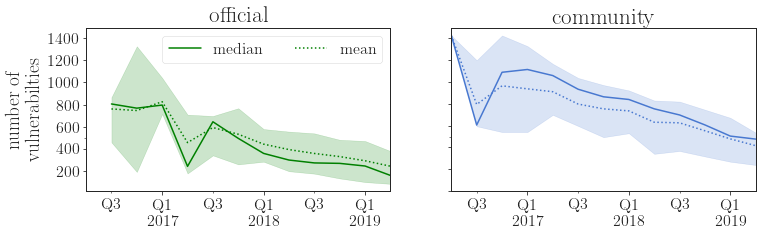

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(image_vuls.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1q'))['cve'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel='number of \nvulnerabilties',
        title=genre)
    plt.yticks(pd.np.arange(0, 1500, 200))
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove() #handles=legend_elements, 

# Vulnerabilty Lag

In [22]:
# Compute the lag
image_vuls['cve_lag'] = image_vuls['cve'] - image_vuls['l_cve']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


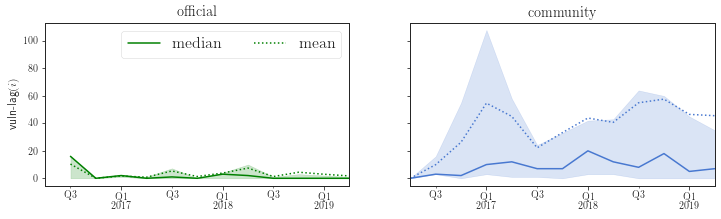

In [23]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(image_vuls.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1q'))['cve_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel=r'$\vulnlag(i)$',
        title=genre)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove() 

In [28]:
# Mann-whitney u test
print(scipy.stats.mannwhitneyu(image_vuls.query('type=="community"').cve_lag, 
        image_vuls.query('type=="official"').cve_lag))

['Stable', 'Testing'] MannwhitneyuResult(statistic=297017600.0, pvalue=0.0)


In [30]:
# Mann-whitney u test
print(effect_size.cliffsDelta(image_vuls.query('type=="official"').cve_lag, 
        image_vuls.query('type=="community"').cve_lag))

d=0.5145893933542466
True


In [24]:
image_vuls.cve_lag.median()

8.0

## Considering Debian Release

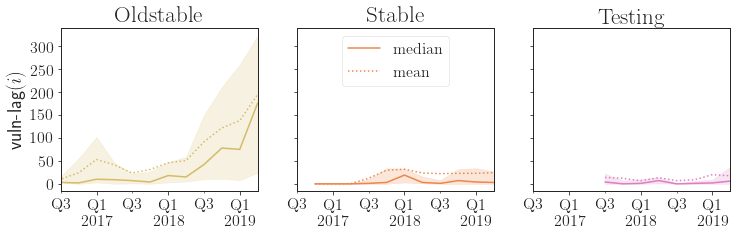

In [26]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['Oldstable','Stable','Testing']):
    size=[12,20,70]
    df_=(image_vuls.
         query('release=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['cve_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel=r'$\vulnlag(i)$',
        title=genre,
        xlim=date_period)
    plt.yticks(pd.np.arange(0, 350, 50))
    ax.xaxis.set_minor_locator(minorLocator)
    if index==1:
        ax.legend(loc='upper center', prop={'size': 16}, ncol=1) #handles=legend_elements,
    else:
        ax.legend('').remove()

In [31]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(image_vuls.query('release=="'+x[0]+'"').cve_lag, 
            image_vuls.query('release=="'+x[1]+'"').cve_lag))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1522670195.0, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=61248772.0, pvalue=0.0)
['Stable', 'Testing'] MannwhitneyuResult(statistic=140875728.0, pvalue=1.6009026112647537e-26)


In [33]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(image_vuls.query('release=="'+x[0]+'"').cve_lag, 
            image_vuls.query('release=="'+x[1]+'"').cve_lag))

d=0.32415220030490516
['Oldstable', 'Stable'] True
d=0.42851508002827066
['Oldstable', 'Testing'] True
d=0.09811103653827004
['Stable', 'Testing'] False


In [76]:
image_vuls['Low'] = image_vuls['Low'] - image_vuls['l_Low']
image_vuls['Medium'] = image_vuls['Medium'] - image_vuls['l_Medium']
image_vuls['High'] = image_vuls['High'] - image_vuls['l_High']

In [98]:
for release in ['Testing','Stable','Oldstable']:
    print(release, image_vuls.query('release =="{}"'.format(release)).cve_lag.median())

Testing 2.0
Stable 4.0
Oldstable 21.0


/home/neglectos/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


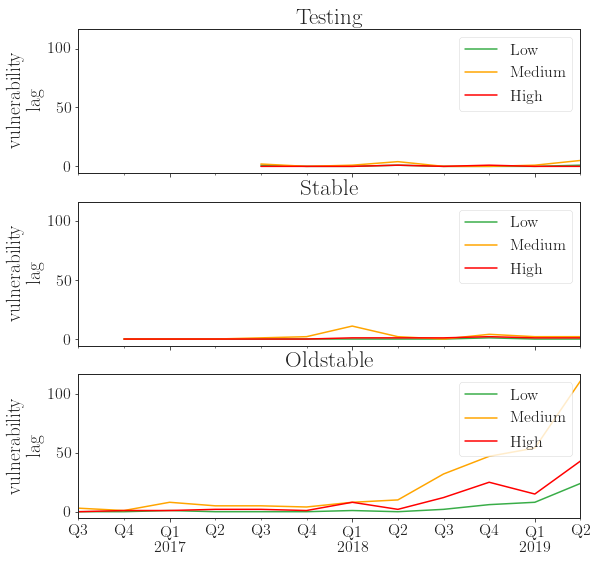

In [90]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for j, release in enumerate(['Testing','Stable','Oldstable']):
    df_=(image_vuls.
         query('release =="{}"'.format(release)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))[['Low','Medium','High']].
         median()
        )
    color = colors[release]
    
    ax=df_.plot(ax=axes[j], colors=[colors[x] for x in ['Low','Medium','High']])

    ax.set(
        xlabel='',
        ylabel='vulnerability\n lag',
        title=release.capitalize(),    
        xlim=date_period)
    ax.legend(loc='upper right',  prop={'size': 16, 'weight':'bold'})

# Merge all lags

In [93]:
(image_vuls[['image','release','type','last_updated','cve_lag']]
 .to_csv('../../data/for_analysis/image_lags.csv', index=False)
)